## Does polymorphism in BUL2 gene lead to altered amino acid levels in S288c

Evidence for F883L polymorphism @ chrXIII:48814..48814 in BUL2 in S288c background as basis for multiple mQTLs on chr13

[Kwan, E. X., Foss, E., Kruglyak, L., & Bedalov, A. (2011). Natural polymorphism in BUL2 links cellular amino acid availability with chronological aging and telomere maintenance in yeast. PLoS Genet, 7(8), e1002250.](http://journals.plos.org/plosgenetics/article?id=10.1371/journal.pgen.1002250)<br>

<center><img src="http://journals.plos.org/plosgenetics/article/figure/image?size=large&id=info:doi/10.1371/journal.pgen.1002250.g002" width=500px></center>

In [3]:
.libPaths("~/R/x86_64-redhat-linux-gnu-library/3.2/")
# config opts and libraries
options(repr.plot.width = 6)
options(repr.plot.height = 5)
options(jupyter.plot_mimetypes = 'image/png')
library(ggplot2);
library(plyr);
library(dplyr);
library(reshape2);
library(LSD);
library(qtl);
library(pheatmap);
library(funqtl);
library(parallel);
options(mc.cores = 24);
library(snow);
library(igraph);
library(stringr);
library(RColorBrewer);
library(jpeg);
library(pheatmap);
library(GenomicRanges);
library(zoo);

In [4]:
# load data
endo_f = "/g/steinmetz/project/GenPhen/data/endometabolome/data/endometabolite_full_12102015.rda"
load(endo_f)

# use only relaitve data
endometabolite = filter(endometabolite, time_format == "relative")

#head(endometabolite)

In [5]:
# load expression data
load("/g/steinmetz/brooks/genphen/transcriptome/data/trx_df.rda")

In [6]:
# load normalized QTLs
load("/g/steinmetz/brooks/genphen//metabolome/qtls/mQTLs_comball_funqtl_2014.rda")
mQTLs_funqtl_2014_class = sapply(mQTLs_funqtl_2014,class)
mQTLs_funqtl_2014 = mQTLs_funqtl_2014[mQTLs_funqtl_2014_class!="try-error"]

In [159]:
# load eQTLs
load("/g/steinmetz/brooks/genphen/transcriptome/qtl/eQTL_08032016.rda")

In [8]:
# load genotype and markers files
genotype_f = "/g/steinmetz/brooks/yeast/genomes/S288CxYJM789/genotypes_S288c_R64.rda"
load(genotype_f)

In [9]:
# load mQTL-eQTL correlations
load("/g/steinmetz/brooks/genphen//metabolome/qtls/mQTL_eQTL_cor.RData")

###  Metabolite and gene expression levels conditioning on BUL2 SNP @ chrXIII:48814..48814

In [143]:
# find marker at chrXIII:48814..48814
gr <- GRanges(seqnames = Rle(c("chr13")), ranges = IRanges(48814,48814))
bul2_mrk = names(mrk[which(mrk == gr),])

In [144]:
# head(geno)
# add geno column for bul2_mrk to endometabolite data
genotype = geno[bul2_mrk,]
genotype[genotype==1] = "S"
genotype[genotype==2] = "Y"
genotype = data.frame(strain = names(genotype), geno = genotype)

endometabolite = merge(endometabolite,genotype,by = "strain")

In [145]:
# remove strains w/o genotype at this marker
if (length(which(is.na(endometabolite$geno)))>0) {
    data2plot = endometabolite[-which(is.na(endometabolite$geno)),]
}
# remove NA values
if (length(which(is.na(data2plot$value.log2)))>0) {
    data2plot = data2plot[-which(is.na(data2plot$value.log2)),]
}
data2plot$geno = as.factor(data2plot$geno)

In [146]:
mo = data2plot %>% group_by(metabolite) %>% summarise(m_mean = mean(value.log2, na.rm = T))
mo = mo[order(mo$m_mean, decreasing = F),]

In [147]:
data2plot$metabolite = factor(data2plot$metabolite, levels = mo$metabolite)

In [148]:
# average replicates
data2plot = data2plot %>% group_by(metabolite, time, strain) %>% do({
        data.frame(value = mean(.$value.log2, na.rm =T), geno = .$geno[1])
     })

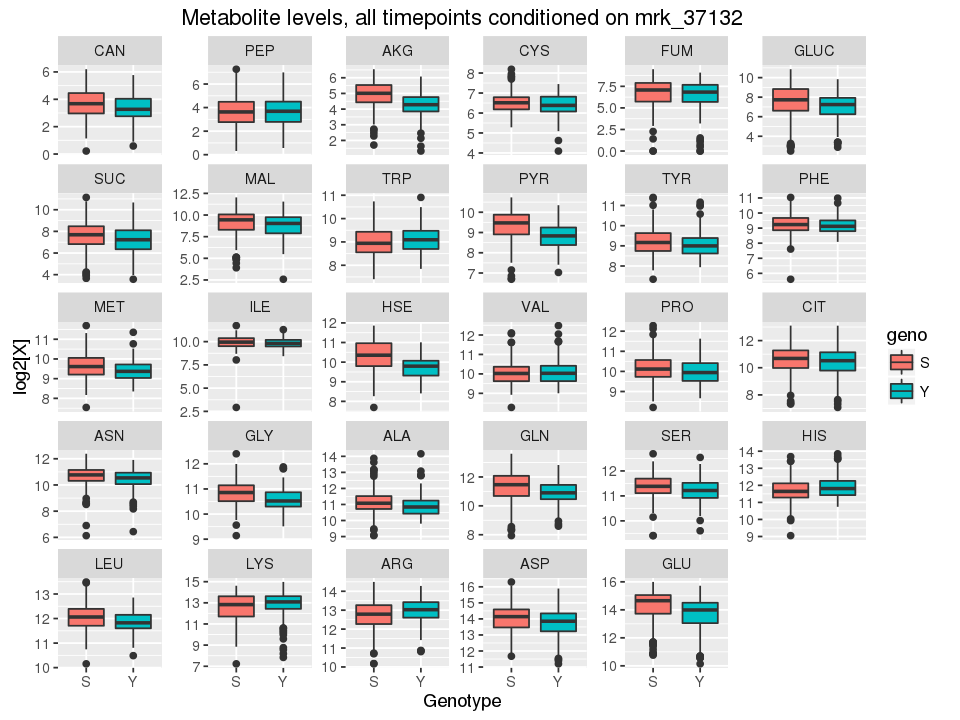

In [149]:
options(repr.plot.height = 6)
options(repr.plot.width = 8)
p <- ggplot(data2plot, aes(geno, value)) + 
    geom_boxplot(aes(fill = geno), show.legend = T) +
    facet_wrap(~ metabolite, scales = "free_y") + 
    labs(title = paste("Metabolite levels, all timepoints conditioned on", bul2_mrk), 
         y = "log2[X]", x = "Genotype") 
p

In [150]:
# restrict to metabolites with mQTL on chr13
load("/g/steinmetz/brooks/genphen/metabolome/qtls/mQTLs_table.rda")
qtls_norm = qtls_norm %>% filter(seqnames == "chrXIII")
m = qtls_norm$metabolite

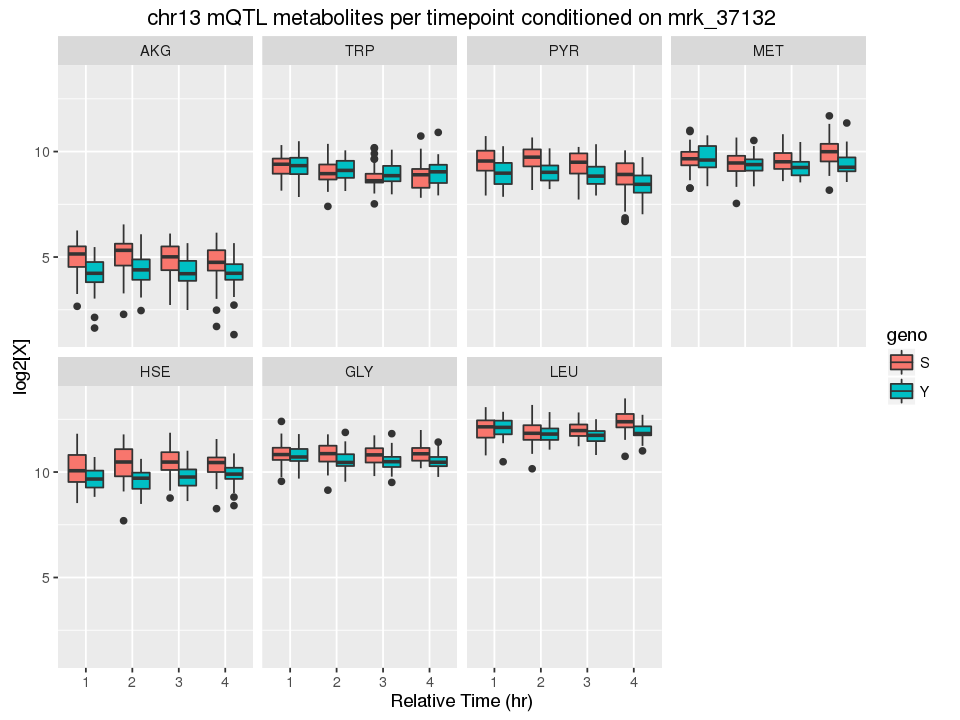

In [151]:
options(repr.plot.width = 8)
options(repr.plot.height = 6)
p <- ggplot(data2plot %>% filter(metabolite %in% m), aes(factor(time), value)) + 
    geom_boxplot(aes(fill = geno), show.legend = T) +
    facet_wrap(~ metabolite, ncol = 4) + 
    labs(title = paste("chr13 mQTL metabolites per timepoint conditioned on", bul2_mrk), 
         y = "log2[X]", x = "Relative Time (hr)") 
p

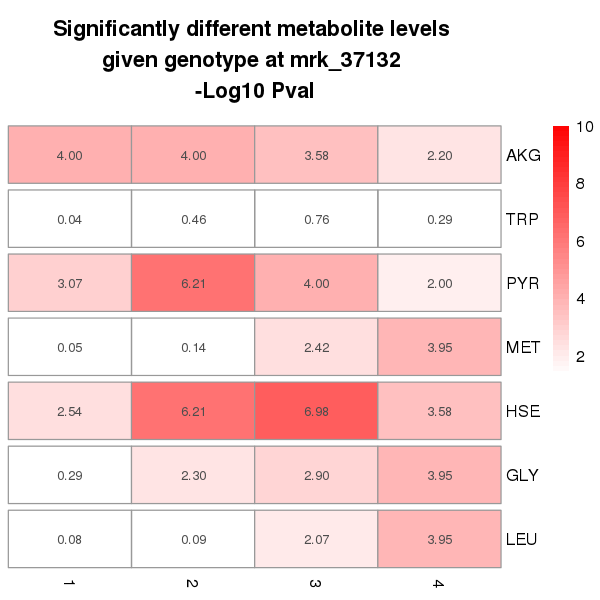

In [152]:
options(repr.plot.width = 5)
options(repr.plot.height = 5)
Mmrk_dif_sig = data2plot %>% filter(metabolite %in% m) %>% group_by(metabolite, time) %>% do({
    data = .
    sparent = data[data$geno=="S","value"]
    yparent = data[data$geno=="Y","value"]
    test = t.test(sparent$value, yparent$value)
    pval = test$p.value
    return(data.frame(pval))
})
Mmrk_dif_sig$pval = -log10(p.adjust(Mmrk_dif_sig$pval,method="BH"))
Mmrk_dif_sig = acast(Mmrk_dif_sig, metabolite ~ time, value.var = "pval")

pheatmap(Mmrk_dif_sig, display_numbers = T,number_format = "%.2f", legend_title = "hi",
         cluster_rows = F, cluster_cols = F, 
         color = colorRampPalette(c("white", "red"))(50), breaks = seq(-log10(0.05),10,length.out = 50),
         gaps_row = seq(1:dim(Mmrk_dif_sig)[1]), 
         main = paste("Significantly different metabolite levels \ngiven genotype at", bul2_mrk , "\n-Log10 Pval")
        )

In [153]:
genotype = geno[bul2_mrk,]
genotype[genotype==1] = "S"
genotype[genotype==2] = "Y"
genotype = data.frame(strain = names(genotype), geno = genotype)

trx2plot = merge(trx_df,genotype,by = "strain")
trx2plot = trx2plot[!is.na(trx2plot$geno),]

### Highly correlated mQTL-eQTL profiles, cor > 0.5

In [154]:
high_cor_mXe = mQTL_eQTL_cor %>% filter(cor >= .5)
gnames = sort(table(high_cor_mXe$gene),decreasing = T)
gnames = names(gnames[gnames>=2])
#gnames

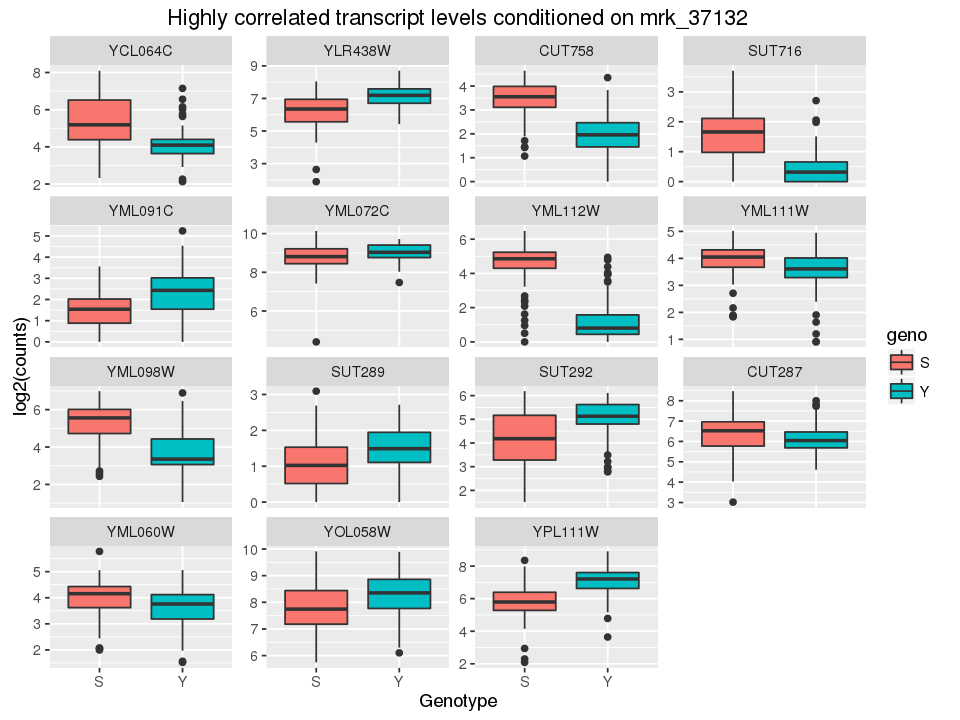

In [155]:
options(repr.plot.width = 8)
options(repr.plot.height = 6)
# average replicates
trx2plot = trx2plot  %>% filter(name %in% gnames) %>% group_by(name, strain) %>% do({
        data.frame(value = mean(log2(.$value+1), na.rm =T), geno = .$geno[1])
     })
p <- ggplot(trx2plot, aes(geno, value)) + 
    geom_boxplot(aes(fill = geno), show.legend = T) +
    facet_wrap(~ name, ncol = 4, scales = "free_y") + 
    labs(title = paste("Highly correlated transcript levels conditioned on", bul2_mrk), 
         y = "log2(counts)", x = "Genotype")

p

### Are any of the differences significant?

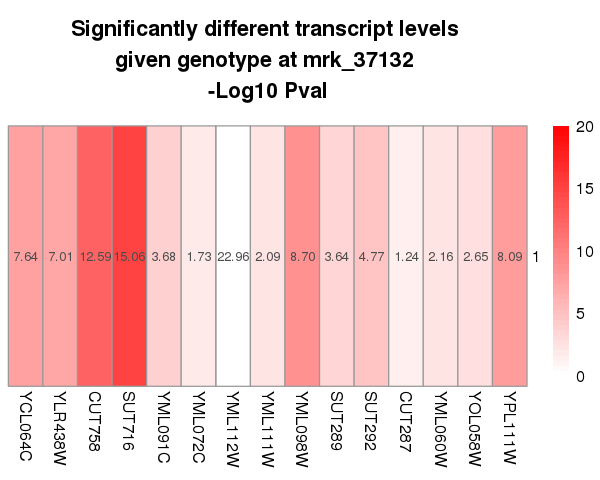

In [156]:
mrk_dif_sig = trx2plot %>% filter(name %in% gnames) %>% group_by(name) %>% do({
    data = .
    sparent = log2(data[data$geno=="S","value"] + 1)
    yparent = log2(data[data$geno=="Y","value"] + 1)
    test = t.test(sparent, yparent)
    pval = test$p.value
    return(data.frame(pval))
})
mrk_dif_sig$pval = p.adjust(mrk_dif_sig$pval,method="BH")
mrk_dif_sig = matrix(-log10(mrk_dif_sig$pval), nrow = 1, ncol = dim(mrk_dif_sig)[1], dimnames = list("1",mrk_dif_sig$name))

options(repr.plot.width = 5)
options(repr.plot.height = 4)
pheatmap(mrk_dif_sig, display_numbers = T,number_format = "%.2f", legend_title = "hi",
         cluster_rows = F, cluster_cols = F, 
         color = colorRampPalette(c("white", "red"))(50), breaks = seq(0,20,length.out = 50),
         main = paste("Significantly different transcript levels \ngiven genotype at", bul2_mrk , "\n-Log10 Pval")
        )


### Plot LOD profiles for these genes

In [157]:
#colnames(eQTL$qtls)

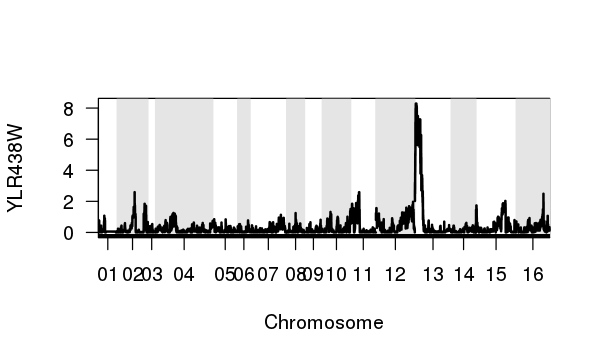

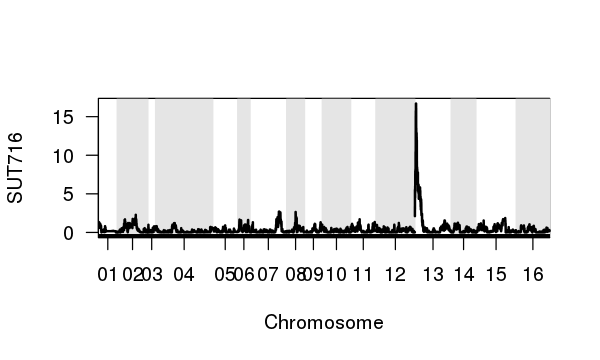

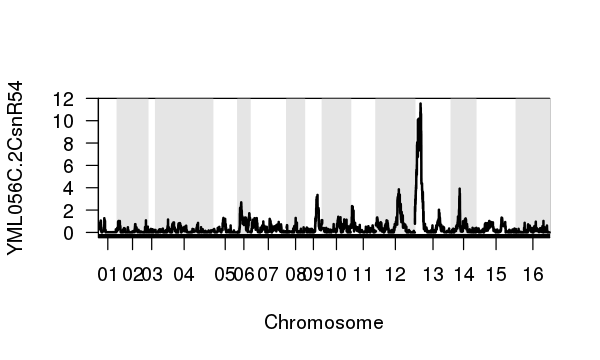

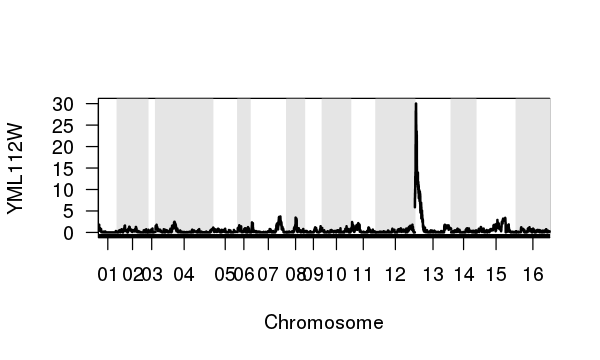

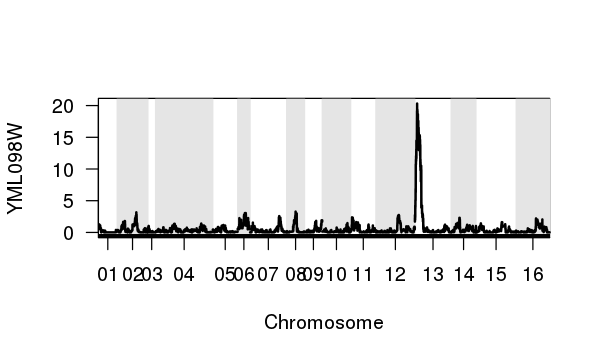

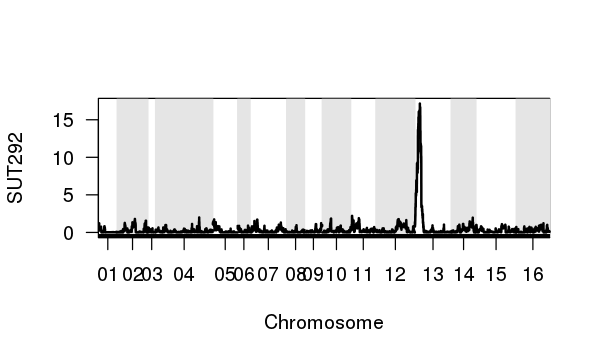

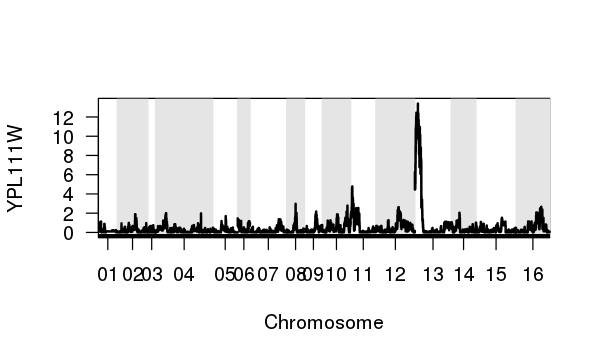

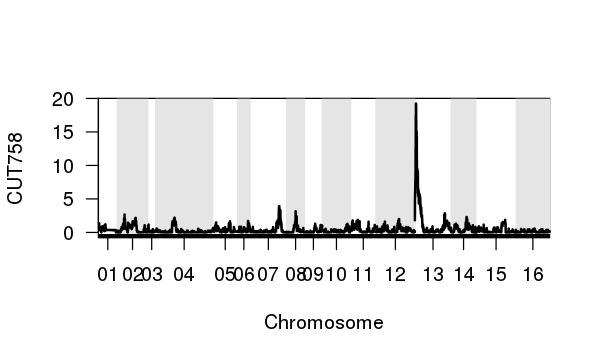

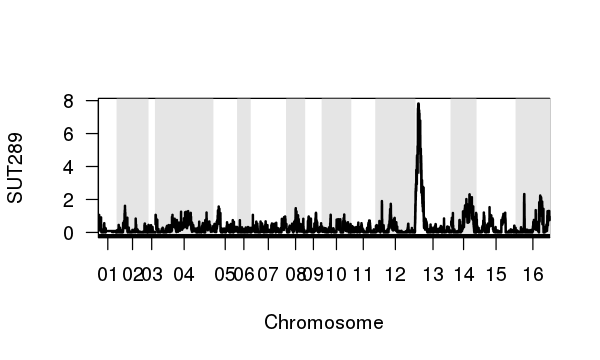

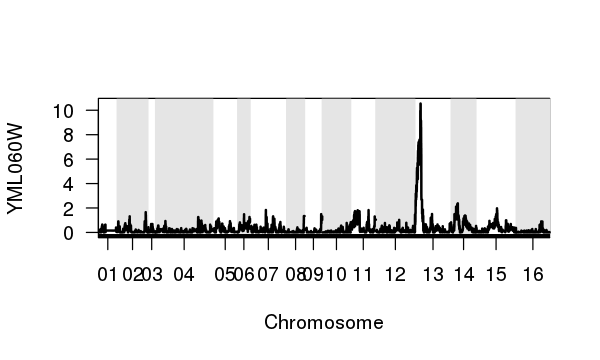

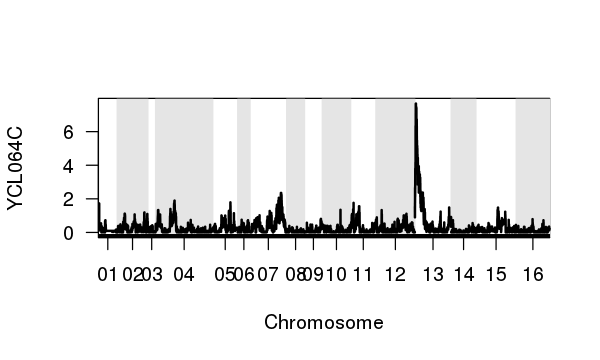

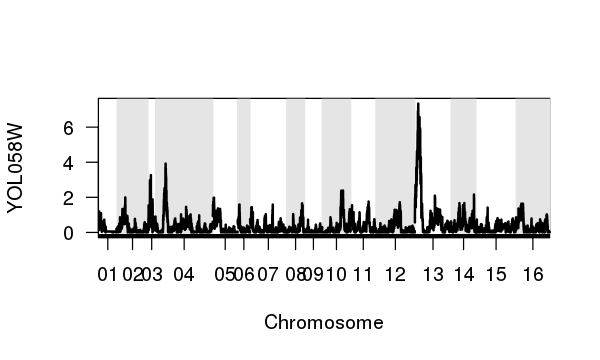

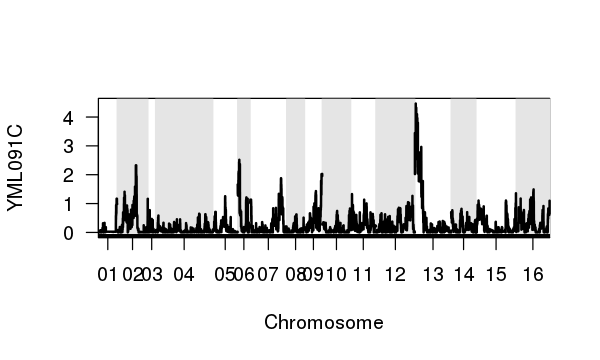

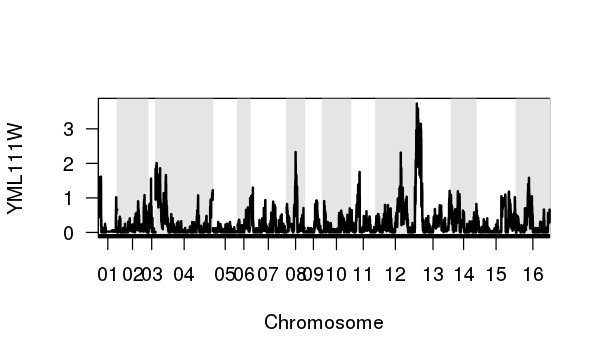

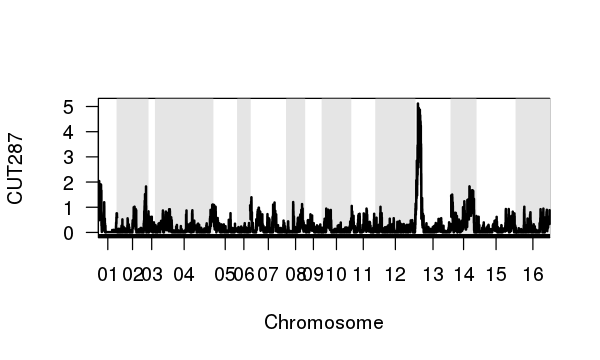

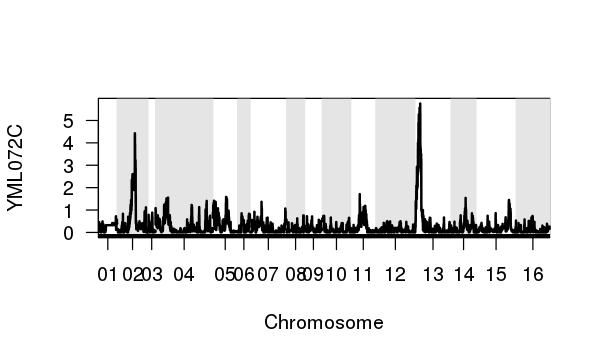

In [160]:
options(repr.plot.height = 3)
for (i in gnames) {
    index = which(colnames(eQTL$qtls)==i)-2
    plot(eQTL$qtls,lodcolumn=index, bandcol="gray90")
}


In [64]:
saveGIF({
    for (i in gnames) {
        index = which(colnames(eQTL$qtls)==i)-2
        plot(eQTL$qtls,lodcolumn=index, bandcol="gray90")
    }
}, movie.name = "eQTL.gif", interval = 2, ani.height = 300, ani.width = 900)

Executing: 
'convert' -loop 0 -delay 200 Rplot1.png Rplot2.png Rplot3.png
    Rplot4.png Rplot5.png Rplot6.png Rplot7.png Rplot8.png Rplot9.png
    Rplot10.png Rplot11.png Rplot12.png Rplot13.png Rplot14.png
    Rplot15.png Rplot16.png 'eQTL.gif'
Output at: eQTL.gif


[1] TRUE